In [8]:
#!pip install fastai --upgrade
#!pip install nbdev
#!pip install azure-cognitiveservices-search-imagesearch
from utils import *
from fastai.vision.all import *

In [13]:
# Download PASCAL dataset
path = untar_data(URLs.PASCAL_2007)

In [15]:
# Dataset comes with a .CSV file telling us labels for each image
df = pd.read_csv(path/'train.csv')

In [23]:
df.head()

AttributeError: ignored

        fname        labels  is_valid
0  000005.jpg         chair      True
1  000007.jpg           car      True
2  000009.jpg  horse person      True
3  000012.jpg           car     False
4  000016.jpg       bicycle      True

## Pandas and DataFrames

In [24]:
df.iloc[:,0]

0       000005.jpg
1       000007.jpg
2       000009.jpg
3       000012.jpg
4       000016.jpg
           ...    
5006    009954.jpg
5007    009955.jpg
5008    009958.jpg
5009    009959.jpg
5010    009961.jpg
Name: fname, Length: 5011, dtype: object

In [25]:
df.iloc[0,:]

fname       000005.jpg
labels           chair
is_valid          True
Name: 0, dtype: object

In [26]:
df['fname']

0       000005.jpg
1       000007.jpg
2       000009.jpg
3       000012.jpg
4       000016.jpg
           ...    
5006    009954.jpg
5007    009955.jpg
5008    009958.jpg
5009    009959.jpg
5010    009961.jpg
Name: fname, Length: 5011, dtype: object

In [31]:
df1 = pd.DataFrame()
df1['a'] = [1,2,3,4]

In [36]:
df1['b'] = [10,20,30,40]

In [38]:
#df1['a'] + df1['b']

## Constructing a data block

* Data set is anything that I can index into and take the length of.

### Lecture Content here

In [48]:
a = list(enumerate(string.ascii_lowercase))
a[0], len(a)

((0, 'a'), 26)

In [49]:
dl_a = DataLoader(a, batch_size=8, shuffle=True)
b = first(dl_a)
b

(tensor([ 7, 24, 17, 21,  5, 19,  9, 15]),
 ('h', 'y', 'r', 'v', 'f', 't', 'j', 'p'))

In [50]:
list(zip(b[0], b[1]))

[(tensor(7), 'h'),
 (tensor(24), 'y'),
 (tensor(17), 'r'),
 (tensor(21), 'v'),
 (tensor(5), 'f'),
 (tensor(19), 't'),
 (tensor(9), 'j'),
 (tensor(15), 'p')]

In [51]:
# Same as above
# *b - insert into this parameter list each element of b
list(zip(*b))

[(tensor(7), 'h'),
 (tensor(24), 'y'),
 (tensor(17), 'r'),
 (tensor(21), 'v'),
 (tensor(5), 'f'),
 (tensor(19), 't'),
 (tensor(9), 'j'),
 (tensor(15), 'p')]

In [52]:
a = list(string.ascii_lowercase)
a[0], len(a)

('a', 26)

In [53]:
dss = Datasets(a)
dss[0]

('a',)

In [54]:
def f1(o):
  return o+'a'

def f2(o):
  return o+'b'

In [57]:
dss = Datasets(a, [[f1]]) # list of transformations to do
dss[0]

('aa',)

In [58]:
dss = Datasets(a, [[f1, f2]])
dss[0]

('aab',)

In [61]:
dls = DataLoaders.from_dsets(dss, batch_size=4)
first(dls.train)

(('ra', 'sa', 'ka', 'wa'), ('rb', 'sb', 'kb', 'wb'))

In [60]:
dss = Datasets(a, [[f1], [f2]])
dss[0]
# This is how we do with fastai
# first function gets filename and opens image
# second function gets label

('aa', 'ab')

### Book Content here

In [63]:
# Data block created with no parameters
dblock = DataBlock()
dsets = dblock.datasets(df)

In [64]:
len(dsets.train), len(dsets.valid)

(4009, 1002)

In [69]:
x, y = dsets.train[0]
x,y
# Copies row from DataFrame twice

(fname       008160.jpg
 labels      car person
 is_valid          True
 Name: 4107, dtype: object, fname       008160.jpg
 labels      car person
 is_valid          True
 Name: 4107, dtype: object)

In [70]:
x['fname']

'008160.jpg'

In [71]:
dblock = DataBlock(get_x = lambda r: r['fname'], get_y = lambda r: r['labels'])
dsets = dblock.datasets(df)
dsets.train[0]

('001536.jpg', 'tvmonitor person')

In [72]:
def get_x(r):
  return r['fname']

def get_y(r):
  return r['labels']

dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)

dsets.train[0]

('003608.jpg', 'car')

In [75]:
# We need to convert filename into complete path
# We also need to split categories on space

Path.BASE_PATH = path

def get_x(r):
  return path/'train'/r['fname']

def get_y(r):
  return r['labels'].split(' ')

dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)

dsets.train[0]

(Path('train/002155.jpg'), ['motorbike'])

In [86]:
dblock = DataBlock(blocks= (ImageBlock, MultiCategoryBlock),
                   get_x = get_x, get_y = get_y)

dsets = dblock.datasets(df)

dsets.train[0]

(PILImage mode=RGB size=500x375,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]))

In [87]:
# Let's check which categories are represented in this example
idxs = torch.where(dsets.train[0][1]==1.)[0]
dsets.train.vocab[idxs]

(#1) ['person']

By default, DataBlock uses a random split. To explicitly choose the elements of our validation set, we need to write a function and pass it to `splitter`. It will take the items and return two or more lists of integers

In [90]:
def splitter(df):
  train = df.index[~df['is_valid']].tolist()
  valid = df.index[df['is_valid']].tolist()
  return train,valid

dblock = DataBlock(blocks = (ImageBlock, MultiCategoryBlock),
                   splitter = splitter,
                   get_x = get_x,
                   get_y = get_y)

dsets = dblock.datasets(df)

dsets.train[0]

(PILImage mode=RGB size=500x333,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

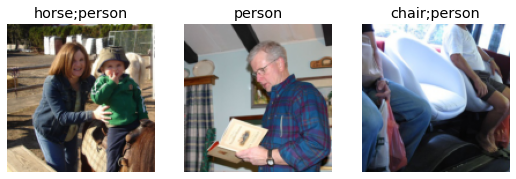

In [91]:
dblock = DataBlock(blocks = (ImageBlock, MultiCategoryBlock),
                   splitter = splitter,
                   get_x = get_x,
                   get_y = get_y,
                   item_tfms = RandomResizedCrop(128, min_scale=0.35))

dls = dblock.dataloaders(df)

dls.show_batch(nrows=1, ncols=3)

In [95]:
#dblock.summary(df)

## Binary Cross Entropy

In [107]:
learn = cnn_learner(dls, resnet18)

In [110]:
x, y = dls.train.one_batch()
learn.model.cuda() # move training to GPU
activs = learn.model(x) # activations from final layer
activs.shape

torch.Size([64, 20])

In [112]:
activs[0]

tensor([-3.9734,  0.8056,  2.5980,  1.3809,  0.7274, -0.8703,  1.4213, -2.4823, -2.2871,  0.4079, -0.4112,  1.0096, -0.4653, -5.1112, -6.3386,  3.6026,  1.0630, -0.1720, -1.9206,  3.0748],
       device='cuda:0', grad_fn=<SelectBackward>)

In [113]:
def binary_cross_entropy(inputs, targets):
  inputs = inputs.sigmoid()
  return -torch.where(targets==1, inputs, 1-inputs).log().mean()

In [115]:
loss_func = nn.BCEWithLogitsLoss()
loss = loss_func(activs, y)
loss

tensor(1.1320, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)

fastai will automatically choose `nn.BCEWithLogitsLoss` by default when it knows that the `DataLoaders` have multiple category labels.

In [119]:
def say_hello(name, say_what='Hello'):
  return f'{say_what} {name}.'

say_hello('Jeremy')

'Hello Jeremy.'

In [120]:
say_hello('Jeremy', 'Ahoy!')

'Ahoy! Jeremy.'

In [121]:
# french version
f = partial(say_hello, say_what='Bonjour')
f('Jeremy')

'Bonjour Jeremy.'

In [122]:
f('Sylvain')

'Bonjour Sylvain.'

In [123]:
learn = cnn_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.2))
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.944986,0.698165,0.241574,00:27
1,0.827654,0.553592,0.301155,00:27
2,0.606014,0.203109,0.814801,00:27
3,0.360547,0.126541,0.942510,00:27


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.136325,0.116792,0.943984,00:29
1,0.120583,0.106500,0.947610,00:28
2,0.097113,0.102817,0.951713,00:28


In [124]:
learn.metrics = partial(accuracy_multi, thresh=0.1)
learn.validate()

(#2) [0.10281682014465332,0.9309360980987549]

In [127]:
learn.metrics = partial(accuracy_multi, thresh=0.99)
learn.validate()

(#2) [0.10281682014465332,0.9423505067825317]

In [130]:
preds, targs = learn.get_preds()

In [131]:
accuracy_multi(preds, targs, thresh=0.9, sigmoid=False)

tensor(0.9559)

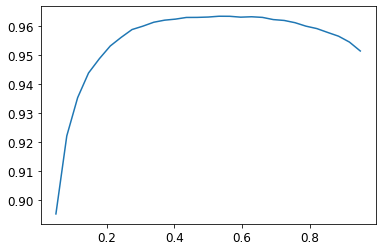

In [132]:
xs = torch.linspace(0.05,0.95,29)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs, accs)